# $Clustering Project$

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

#### *Analysis of the results at the end of this notebook*

## Customer dataset

### • Read Customer dataset and gather quick info 
*N.B: We can assume column 'ID' as index, therefore we will have **7** features*

In [25]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
from scipy.cluster.hierarchy import dendrogram, linkage
# StandardScaler is a function to normalize the data 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline

In [22]:
df = pd.read_csv("Customer_data.csv")
df = df.drop(columns=['ID'])
df.tail()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
1995,1,0,47,1,123525,0,0
1996,1,1,27,1,117744,1,0
1997,0,0,31,0,86400,0,0
1998,1,1,24,1,97968,0,0
1999,0,0,25,0,68416,0,0


In [23]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


### • Normalize Dataset using $MinMaxScaler$

In [30]:
scaler = MinMaxScaler()
df_normalized = df.copy()
features_to_scale = ['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']
df_normalized[features_to_scale] = scaler.fit_transform(df_normalized[features_to_scale])

In [31]:
df_normalized.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,0.308776,0.346000,0.311197,0.405250,0.369500
std,0.498272,0.500113,0.202059,0.199927,0.139321,0.319294,0.406266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.155172,0.333333,0.226048,0.000000,0.000000
50%,0.000000,0.000000,0.258621,0.333333,0.291434,0.500000,0.500000
75%,1.000000,1.000000,0.413793,0.333333,0.373778,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*Now we have 2 datasets, one normalized and one not, with 7 features and 2000 entries*

In [32]:
df_normalized.shape, df.shape

((2000, 7), (2000, 7))

### • Now cluster the dataset

#### $I - $ K-Means 

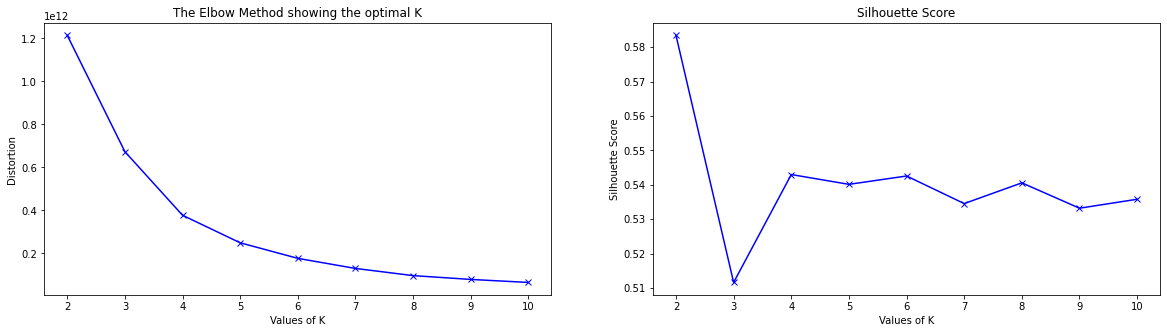

In [35]:
# We will try with different K values 
K_values = [2,3,4,5,6,7,8,9,10]
# Initial empty arrays to store the corresponding values for each K
distortions = []
silhouette_scores = []

for K in K_values:
    # Perform Kmeans clustering using current K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(df)
    
    # Compute distortion (sum of squared distances to closest centroid "J Function")
    distortion = kmeans.inertia_
    distortions.append(distortion)
    
    # Compute silhouette score
    silhouette = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(silhouette)

# One figure to show the distortion function "J" and the silhouette_score 
plt.figure(figsize=(20,5))

# Plot the distortion function versus the number of clusters K
plt.subplot(1,2,1)
plt.plot(K_values, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')

# Plot the silhouette_score versus the number of clusters K
plt.subplot(1,2,2)
plt.plot(K_values, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

>> Optimal at **K=4** with a silhouette score of **0.5429921618470235**

#### $II - $ Hierarchical Clustering 

In [38]:
def visualize_dendogram(data,method,metric):
    linkage_data = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(25,10))
    dendrogram(linkage_data)
    plt.title(f'Dendogram with {metric} affinity and {method} linkage')
    plt.xlabel('points')
    plt.ylabel('distances')
    plt.show()

In [49]:
def agglomerative_clustering(data,T_values,affinity,linkage,silhouette_scores_agglo):
    for T in T_values:
        # Perform Agglomerative clustering
        hierarchical_cluster = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, affinity=affinity,\
                                                        linkage=linkage, distance_threshold=T)
        labels = hierarchical_cluster.fit_predict(data) 
        # Get Unique clusters created, first put them in a set (stores unique elements only), then K = len(set(labels))
        k = set(labels) 
        print("For distance threshold", T, ", Number of clusters = ",len(k))

        # Compute silhouette score
        silhouette_agglo = silhouette_score(data, labels)
        silhouette_scores_agglo.append(silhouette_agglo)

In [40]:
def visualize_silhouette_scores(T_values,silhouette_scores):
    plt.figure(figsize=(20,5))
    plt.plot(T_values, silhouette_scores, 'bx-')
    plt.xlabel('Values of T')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score showing the optimal T')
    plt.show()

##### $A-$ Euclidean Affinity


* $1.A$ Average Linkage

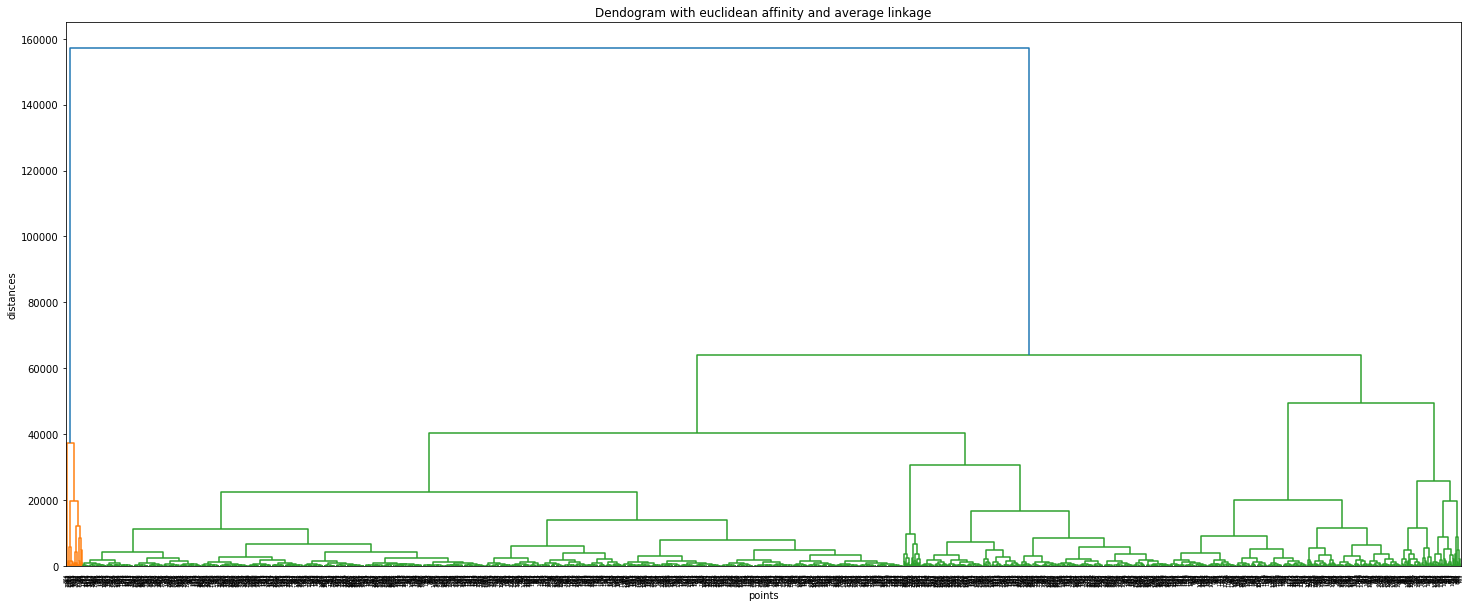

In [41]:
visualize_dendogram(df,'average','euclidean')

For distance threshold 25000 , Number of clusters =  8
For distance threshold 30000 , Number of clusters =  7
For distance threshold 35000 , Number of clusters =  6
For distance threshold 40000 , Number of clusters =  5
For distance threshold 50000 , Number of clusters =  3
For distance threshold 70000 , Number of clusters =  2


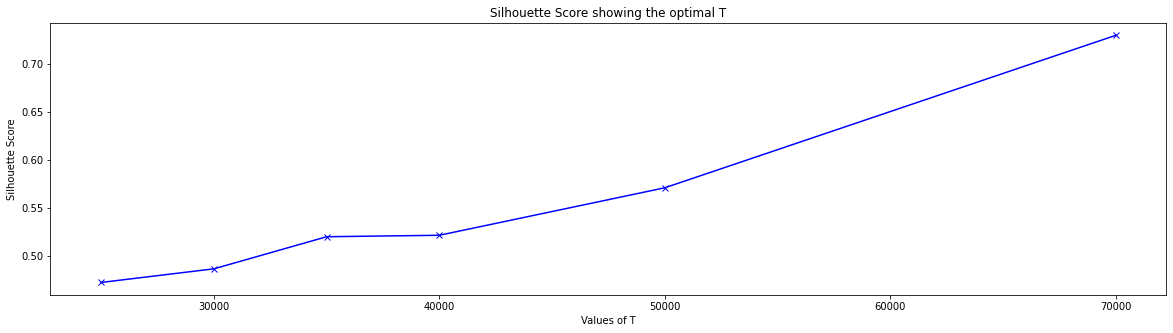

In [57]:
# Choose distance_threshold values according to the dendogram output
euclidean_avg_ts = [25000,30000,35000,40000,50000,70000]
scores_euclidean = []
agglomerative_clustering(df,euclidean_avg_ts,'euclidean','average',scores_euclidean)
visualize_silhouette_scores(euclidean_avg_ts,scores_euclidean)

In [64]:
scores_euclidean[-1]

0.72930877967469

>> At two clusters **K=2**, we get the best silhouette score of **0.72930877967469**

* $2.A$ Single Linkage

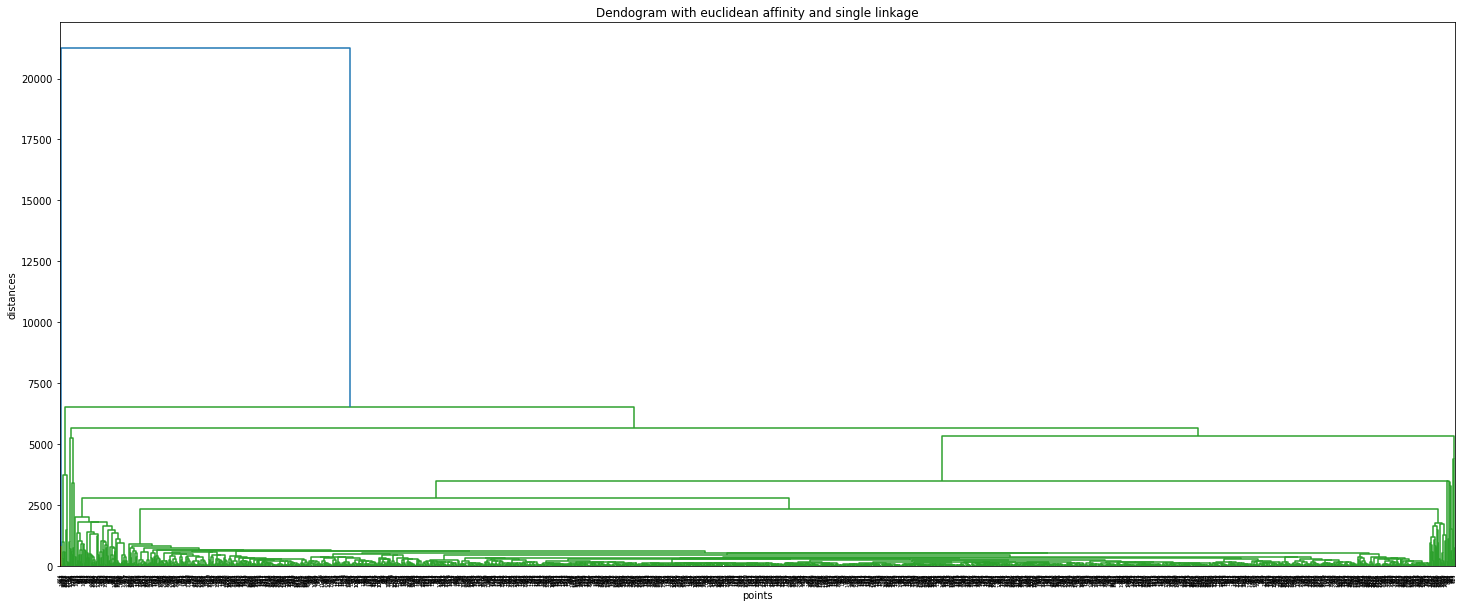

In [51]:
visualize_dendogram(df,'single','euclidean')

For distance threshold 3000 , Number of clusters =  13
For distance threshold 4000 , Number of clusters =  7
For distance threshold 5000 , Number of clusters =  6
For distance threshold 6000 , Number of clusters =  3
For distance threshold 7000 , Number of clusters =  2


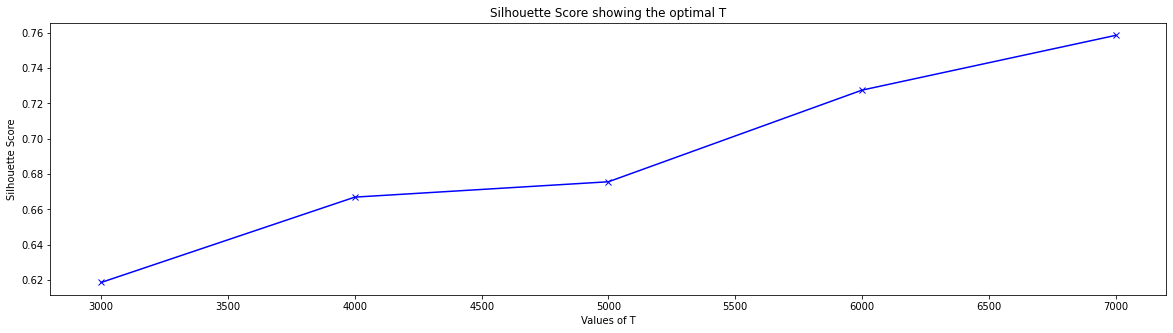

In [53]:
# Choose distance_threshold values according to the dendogram output
euclidean_single_ts = [3000,4000,5000,6000,7000]
scores_euclidean_single = []
agglomerative_clustering(df,euclidean_single_ts,'euclidean','single',scores_euclidean_single)
visualize_silhouette_scores(euclidean_single_ts,scores_euclidean_single)

In [63]:
scores_euclidean_single[-1]

0.7585682251361909

>> At two clusters **K=2**, we get the best silhouette score of **0.7585682251361909**

##### $B-$ Manhattan Affinity


* $1.B$ Average Linkage

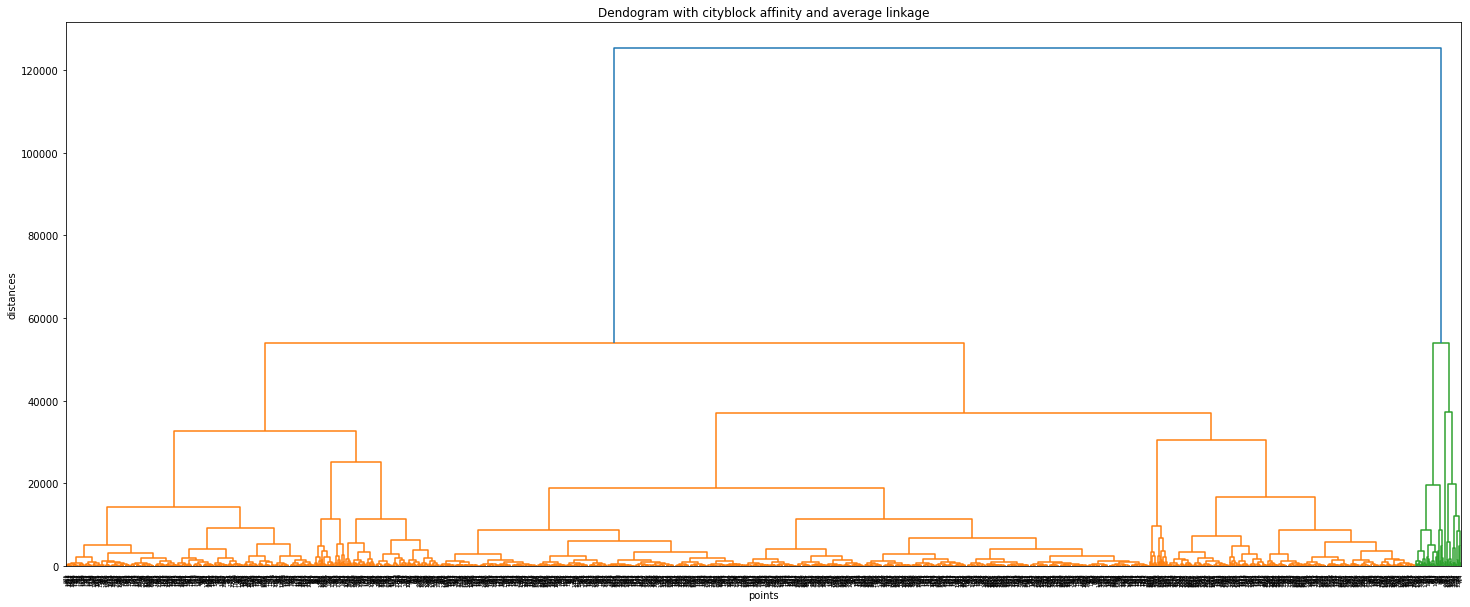

In [65]:
visualize_dendogram(df,'average','cityblock')

For distance threshold 25000 , Number of clusters =  9
For distance threshold 30000 , Number of clusters =  8
For distance threshold 40000 , Number of clusters =  4
For distance threshold 53950 , Number of clusters =  3
For distance threshold 60000 , Number of clusters =  2


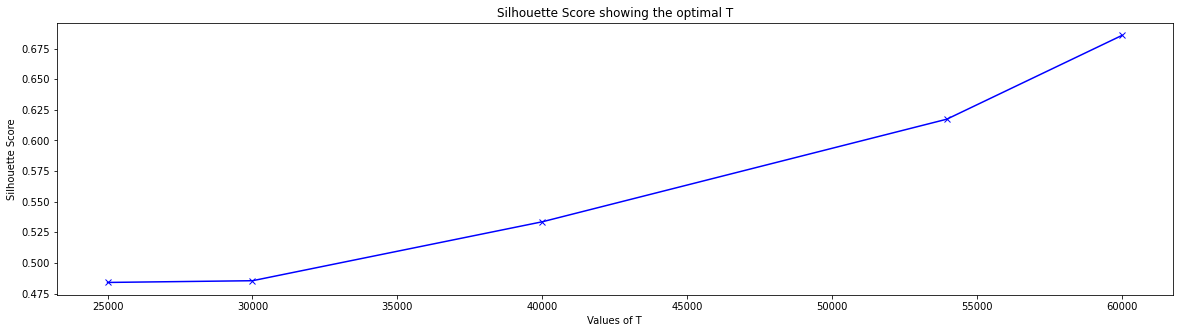

In [74]:
cityblock_avg_ts = [25000,30000,40000,53950,60000]
scores_cityblock = []
agglomerative_clustering(df,cityblock_avg_ts,'manhattan','average',scores_cityblock)
visualize_silhouette_scores(cityblock_avg_ts,scores_cityblock)

In [75]:
scores_cityblock[-1]

0.6857830672441878

>> At two clusters **K=2**, we get the best silhouette score of **0.6857830672441878**

* $2.B$ Single Linkage

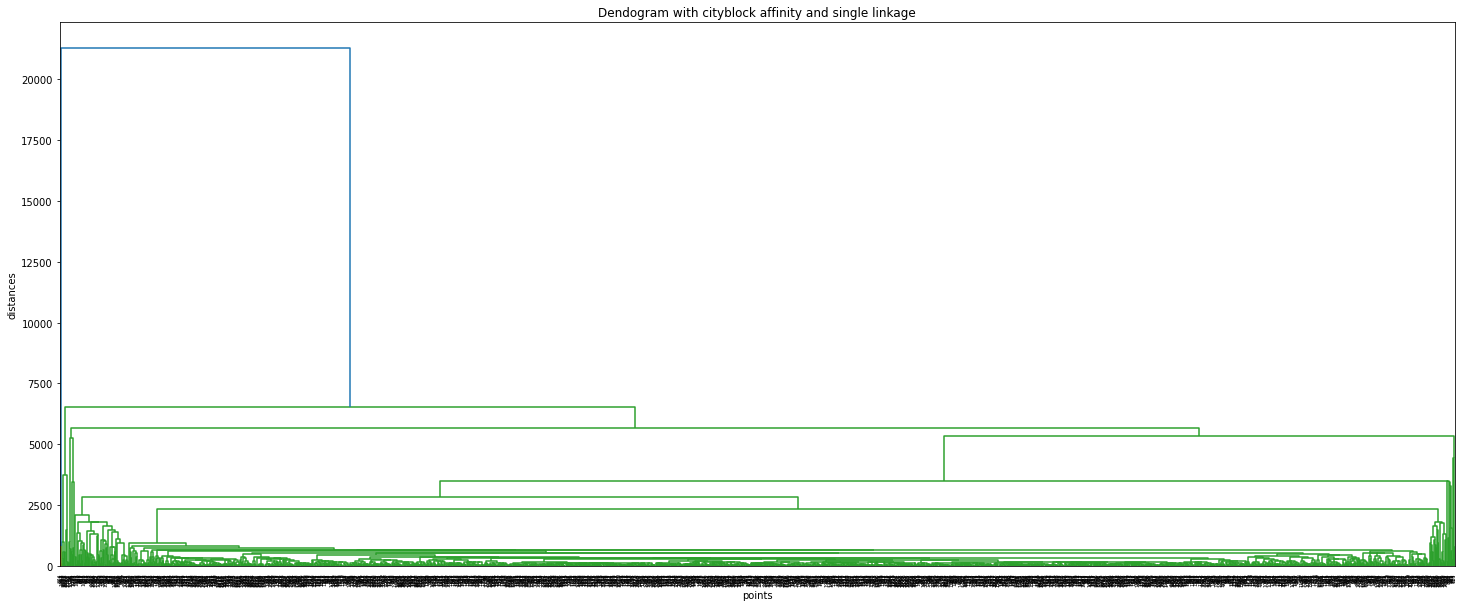

In [76]:
visualize_dendogram(df,'single','cityblock')

For distance threshold 3000 , Number of clusters =  13
For distance threshold 4000 , Number of clusters =  7
For distance threshold 5000 , Number of clusters =  6
For distance threshold 6000 , Number of clusters =  3
For distance threshold 7000 , Number of clusters =  2


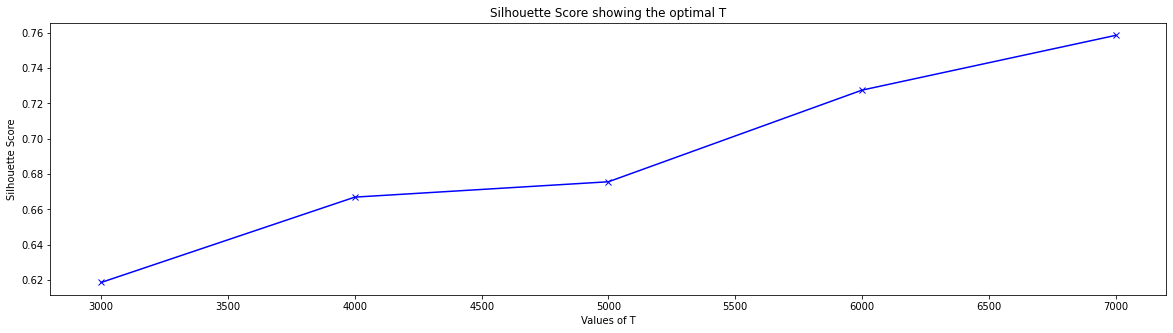

In [78]:
cityblock_single_ts = [3000,4000,5000,6000,7000]
scores_cityblock_single = []
agglomerative_clustering(df,cityblock_single_ts,'manhattan','single',scores_cityblock_single)
visualize_silhouette_scores(cityblock_single_ts,scores_cityblock_single)

In [79]:
scores_cityblock_single[-1]

0.7585682251361909

>> At two clusters **K=2**, we get the best silhouette score of **0.7585682251361909** 

##### $C-$ Cosine Affinity


* $1.C$ Average Linkage

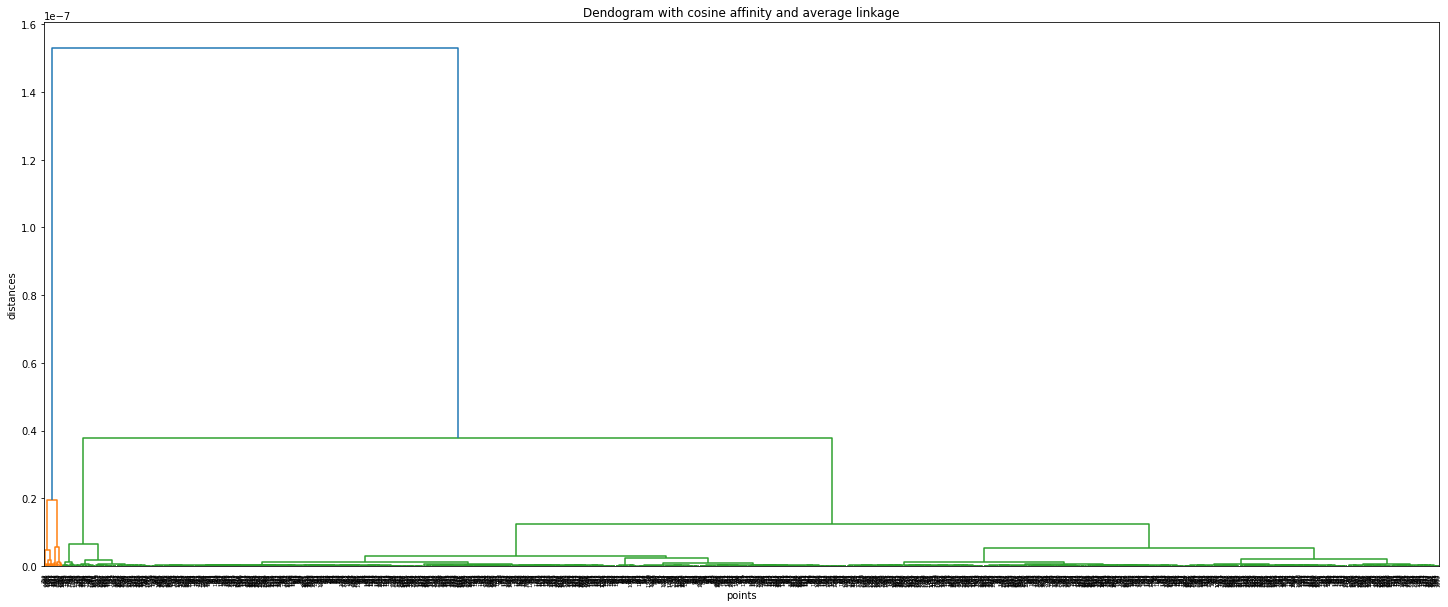

In [80]:
visualize_dendogram(df,'average','cosine')

For distance threshold 5e-09 , Number of clusters =  8
For distance threshold 1e-08 , Number of clusters =  5
For distance threshold 2e-08 , Number of clusters =  3
For distance threshold 4e-08 , Number of clusters =  2


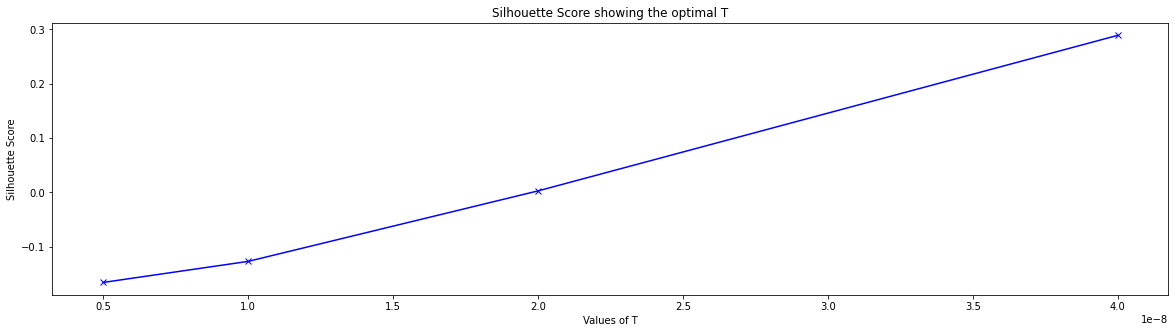

In [83]:
cosine_avg_ts = [0.05e-7,0.1e-7,0.2e-7,0.4e-7]
scores_cosine = []
agglomerative_clustering(df,cosine_avg_ts,'cosine','average',scores_cosine)
visualize_silhouette_scores(cosine_avg_ts,scores_cosine)

In [84]:
scores_cosine[-1]

0.28907449359272075

>> At two clusters **K=2**, we get the best silhouette score of **0.28907449359272075**

* $2.C$ Single Linkage

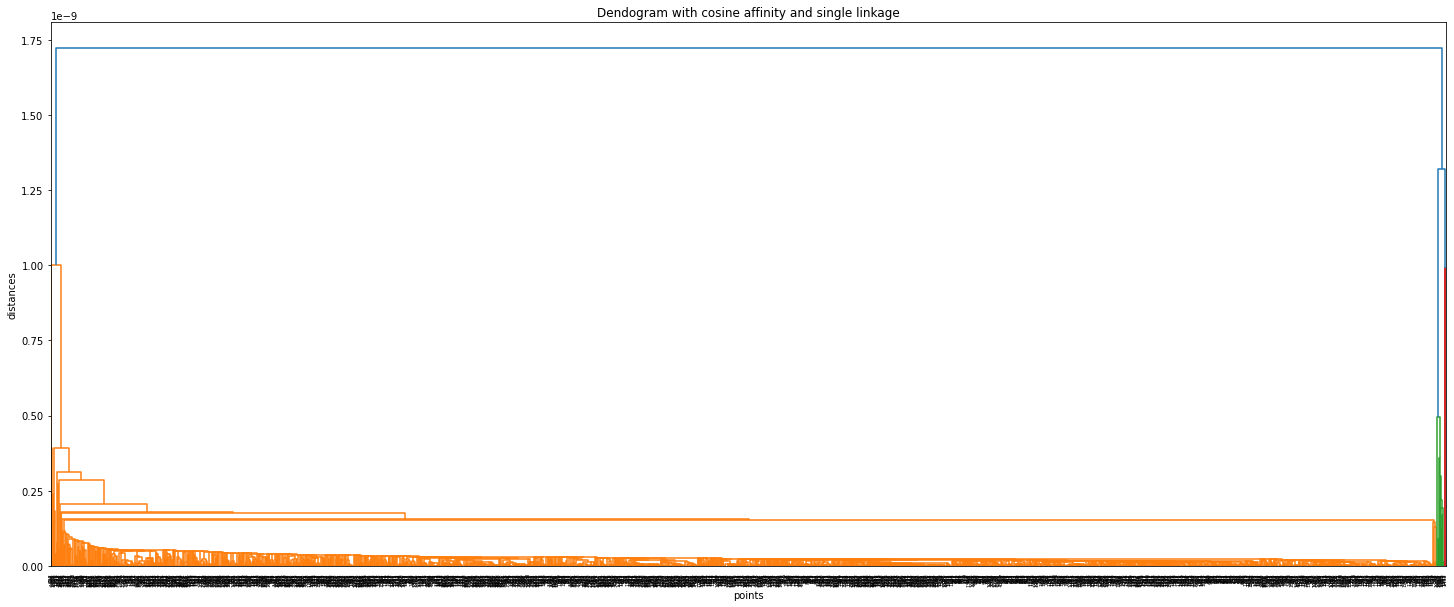

In [85]:
visualize_dendogram(df,'single','cosine')

For distance threshold 3.75e-10 , Number of clusters =  8
For distance threshold 5e-10 , Number of clusters =  5
For distance threshold 7.5e-10 , Number of clusters =  5
For distance threshold 1.2e-09 , Number of clusters =  3
For distance threshold 1.5e-09 , Number of clusters =  2


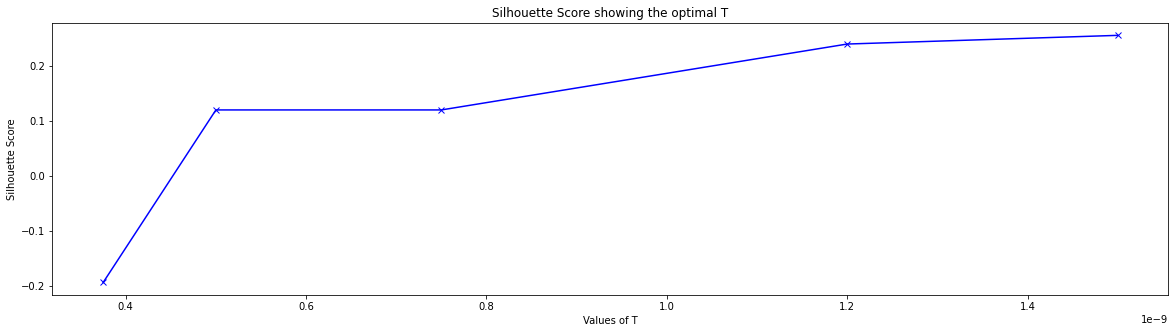

In [86]:
cosine_single_ts = [0.375e-9,0.5e-9,0.75e-9,1.2e-9,1.5e-9]
scores_cosine_single = []
agglomerative_clustering(df,cosine_single_ts,'cosine','single',scores_cosine_single)
visualize_silhouette_scores(cosine_single_ts,scores_cosine_single)

In [87]:
scores_cosine_single[-1]

0.2558101134617697

>> At two clusters **K=2**, we get the best silhouette score of **0.2558101134617697**

#### $III - $ DBSCAN

In [89]:
def dbscan_clustering(data,eps_values,min_samples,silhouette_scores_dbscan):
    for e in eps_values:
        # Perform DBSCAN 
        db = DBSCAN(eps=e, min_samples=min_samples).fit(data)
        labels = db.labels_
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels))
        print("For epsilon value of ", e,", Number of clusters = ",n_clusters_)
        # Compute silhouette score
        silhouette_db = silhouette_score(data, labels)
        silhouette_scores_dbscan.append(silhouette_db)

In [90]:
def visualize_silhouette_scores_db(eps_values,silhouette_scores):
    plt.figure(figsize=(20,5))
    plt.plot(eps_values, silhouette_scores, 'bx-')
    plt.xlabel('Values of EPS')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score showing the optimal EPS')
    plt.show()

### $A - $ MinSamples = 5

For epsilon value of  1000 , Number of clusters =  8
For epsilon value of  2000 , Number of clusters =  7
For epsilon value of  2500 , Number of clusters =  4
For epsilon value of  3000 , Number of clusters =  3
For epsilon value of  4000 , Number of clusters =  4
For epsilon value of  10000 , Number of clusters =  2


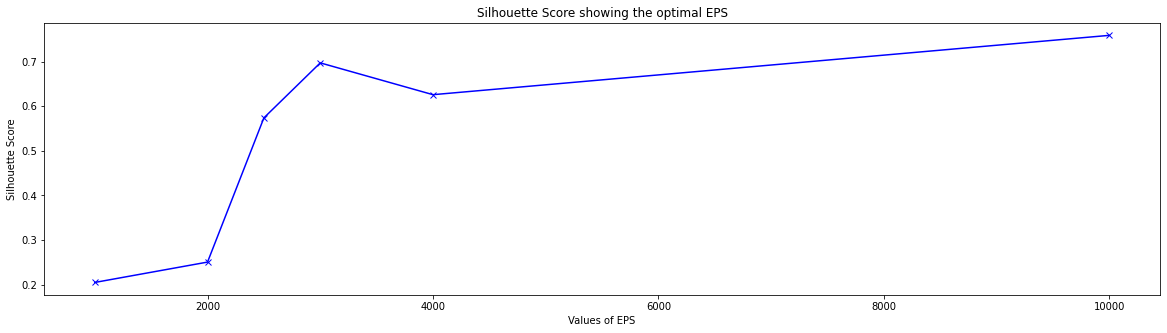

In [103]:
eps_values_m5 = [1000,2000,2500,3000,4000,10000]
silhouette_scores_db5 = []
dbscan_clustering(df,eps_values_m5,5,silhouette_scores_db5)
visualize_silhouette_scores_db(eps_values_m5,silhouette_scores_db5)

In [104]:
silhouette_scores_db5[-1]

0.7585682251361909

>> At two clusters **K=2**, we get the best silhouette score of **0.7585682251361909**

### $B- $ MinSamples = 12

For epsilon value of  870 , Number of clusters =  7
For epsilon value of  900 , Number of clusters =  5
For epsilon value of  1000 , Number of clusters =  4
For epsilon value of  1500 , Number of clusters =  3
For epsilon value of  3000 , Number of clusters =  6


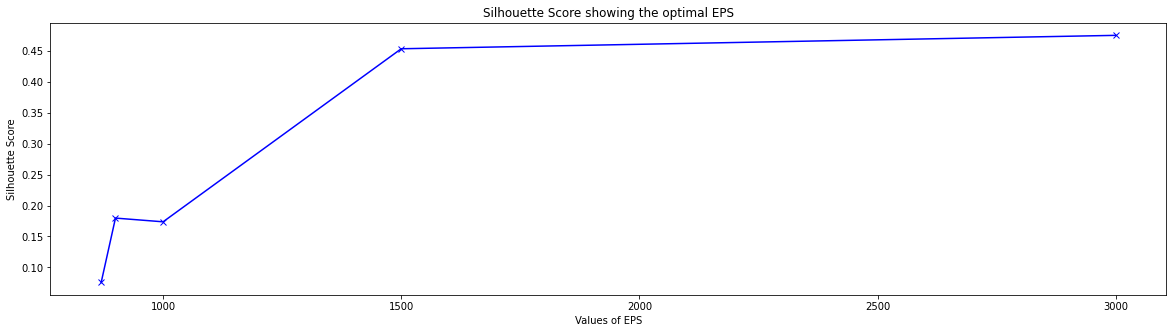

In [120]:
eps_values_m12 = [870,900,1000,1500,3000]
silhouette_scores_db12 = []
dbscan_clustering(df,eps_values_m12,12,silhouette_scores_db12)
visualize_silhouette_scores_db(eps_values_m12,silhouette_scores_db12)

In [121]:
silhouette_scores_db12[-1]

0.47504380511491584

>> At six clusters **K=6**, we get the best silhouette score of **0.47504380511491584**

### $C - $ MinSamples = 19

For epsilon value of  900 , Number of clusters =  10
For epsilon value of  1000 , Number of clusters =  5
For epsilon value of  2000 , Number of clusters =  2
For epsilon value of  3000 , Number of clusters =  3


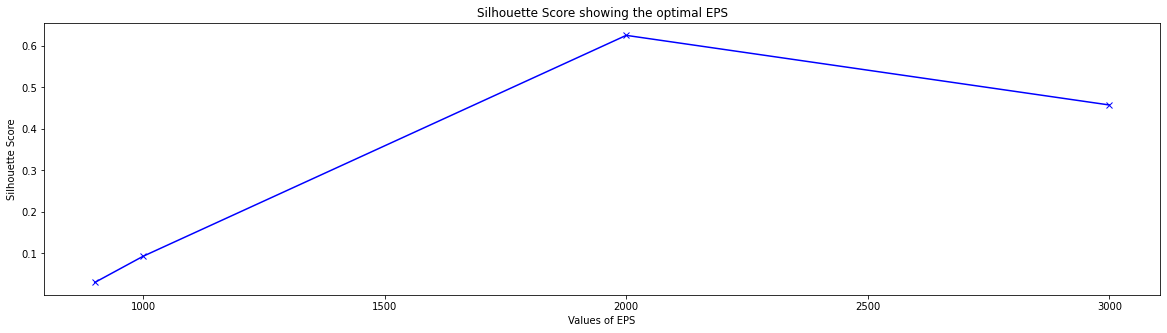

In [126]:
eps_values_m19 = [900,1000,2000,3000]
silhouette_scores_db19 = []
dbscan_clustering(df,eps_values_m19,19,silhouette_scores_db19)
visualize_silhouette_scores_db(eps_values_m19,silhouette_scores_db19)

In [127]:
silhouette_scores_db19[-1]

0.4574148713841917

>> At two clusters **K=2**, we get the best silhouette score of **0.4574148713841917**

### $D - $ MinSamples = 25

For epsilon value of  1000 , Number of clusters =  8
For epsilon value of  1200 , Number of clusters =  6
For epsilon value of  1500 , Number of clusters =  4
For epsilon value of  2300 , Number of clusters =  3
For epsilon value of  3000 , Number of clusters =  2


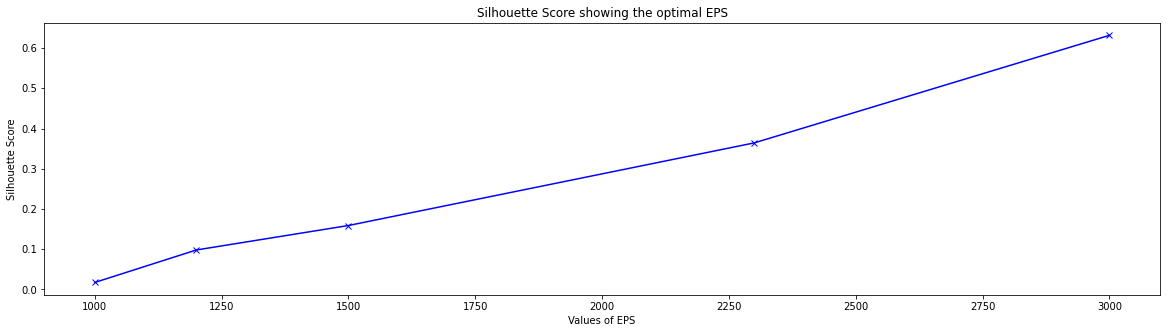

In [134]:
eps_values_m25 = [1000,1200,1500,2300,3000]
silhouette_scores_db25 = []
dbscan_clustering(df,eps_values_m25,25,silhouette_scores_db25)
visualize_silhouette_scores_db(eps_values_m25,silhouette_scores_db25)

In [135]:
silhouette_scores_db25[-1]

0.6316648481281196

>> At two clusters **K=2**, we get the best silhouette score of **0.6316648481281196**

#### $IV - $ GMM 

In [142]:
def gmm_clustering(num_clusters, X):
    n_components = num_clusters # Number of clusters
    covariance_types = ['full', 'tied', 'diag', 'spherical']

    # Initialize GMM models for each covariance type
    gmm_models = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
                for cov_type in covariance_types}

    silhouette_score_gmm = [] # Initialize silhouette score list

    # Fit GMM models for each covariance type
    for cov_type, gmm_model in gmm_models.items():
        gmm_model.fit(X)

        # Predict the cluster assignments for all data points
        predictions = gmm_model.predict(X)

        # Calculate silhouette score for each covariance type
        silhouette_score_gmm.append(silhouette_score(X, predictions))

    covariances = {cov_type: gmm_model.covariances_
			for cov_type, gmm_model in gmm_models.items()}

    return silhouette_score_gmm, covariances

In [145]:
def plot_silhouette_scores_gmm(silhouette_score_gmm, covariance_types, num_clusters):
    plt.figure(figsize=(10, 6))
    plt.bar(covariance_types, silhouette_score_gmm)
    plt.xlabel('Covariance Type')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Covariance Types at K = {num_clusters}')
    plt.show()

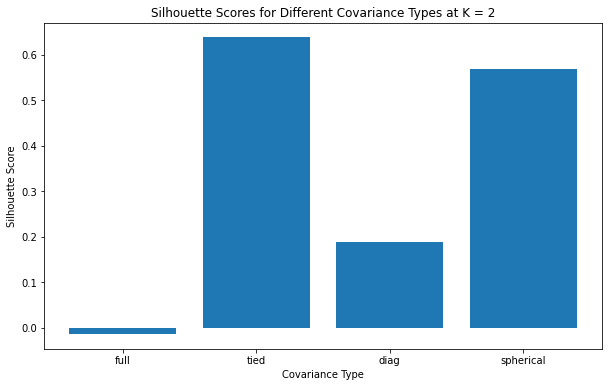

In [147]:
# Call the function
silhouette_score_gmm, _ = gmm_clustering(2,df)
covariance_types = ['full', 'tied', 'diag', 'spherical']
plot_silhouette_scores_gmm(silhouette_score_gmm, covariance_types,2)

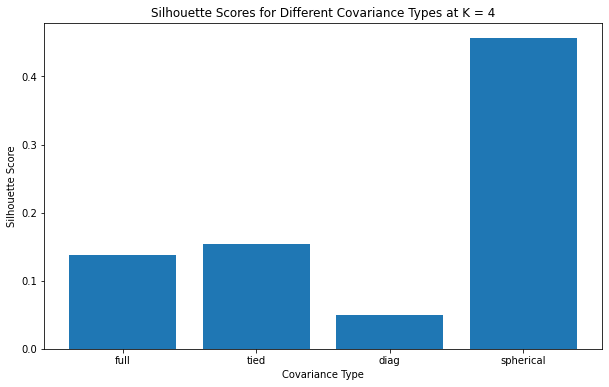

In [148]:
# Call the function
silhouette_score_gmm, _ = gmm_clustering(4,df)
covariance_types = ['full', 'tied', 'diag', 'spherical']
plot_silhouette_scores_gmm(silhouette_score_gmm, covariance_types,4)

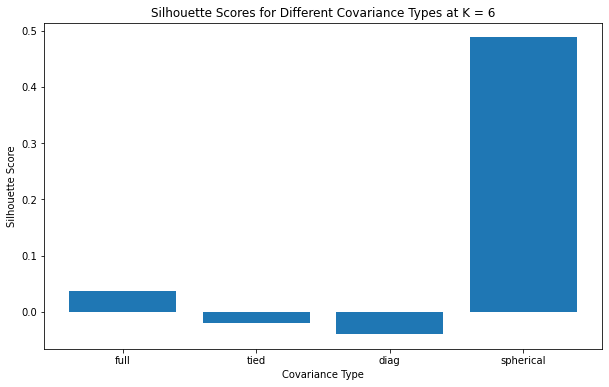

In [149]:
# Call the function
silhouette_score_gmm, _ = gmm_clustering(6,df)
covariance_types = ['full', 'tied', 'diag', 'spherical']
plot_silhouette_scores_gmm(silhouette_score_gmm, covariance_types,6)

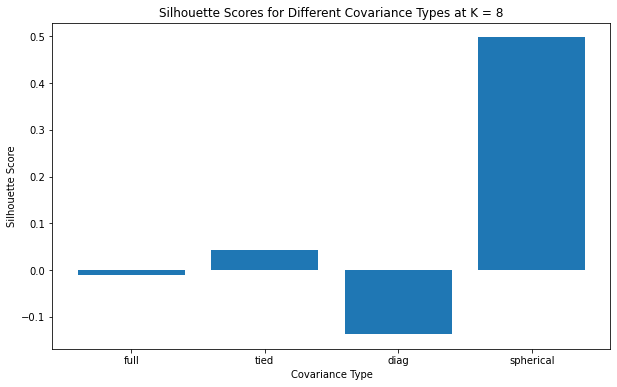

In [150]:
# Call the function
silhouette_score_gmm, _ = gmm_clustering(8,df)
covariance_types = ['full', 'tied', 'diag', 'spherical']
plot_silhouette_scores_gmm(silhouette_score_gmm, covariance_types,8)

## Analysis of the findings: 
* **KMeans:**
    * Optimal at **K=4** with a silhouette score of **0.543**

* **Hierarchical Clustering:**
    * Optimal at **Euclidean/Manhattan** affinity with **Single** linkage, **K=2** with a silhouette score of **0.759**

* **DBSCAN:**
    * Optimal at MinSamples of **5**, but with epsilon value of  **10000**, and **K=2** with a silhouette score of **0.759**

* **GMM:**
    * Optimal at **Tied covariance** type with **K=2**, with a silhouette score of **0.681**

### *Another notebook for the scaled version of the data*